In [58]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer


# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [59]:
# load the provided data
train_features = pd.read_csv('./dataset/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('./dataset/dengue_labels_train.csv',
                           index_col=[0,1,2])

test_features = pd.read_csv('./dataset/dengue_features_test.csv',
                           index_col=[0,1,2])

In [60]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_test_features = test_features.loc['sj']

sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_test_features = test_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [61]:
def preprocess_data(df):
    # load data and set index to city, year, weekofyear    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

#     # add labels to dataframe
#     if labels_path:
#         labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
#         df = df.join(labels)
    
#     # separate san juan and iquitos
#     sj = df.loc['sj']
#     iq = df.loc['iq']
    
    return df

In [80]:
# preprocess
# Remove `week_start_date` string.
# sj_train_features.drop('week_start_date', axis=1, inplace=True)
# iq_train_features.drop('week_start_date', axis=1, inplace=True)
# sj_test_features.drop('week_start_date', axis=1, inplace=True)
# iq_test_features.drop('week_start_date', axis=1, inplace=True)
sj_train_features = preprocess_data(sj_train_features)
iq_train_features = preprocess_data(iq_train_features)
sj_test_features= preprocess_data(sj_test_features)
iq_test_features= preprocess_data(iq_test_features)
print('labels  : ', sj_test_features.shape)
print('labels  : ', sj_train_features.shape)

labels  :  (260, 4)
labels  :  (936, 4)


In [81]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 4)
labels  :  (936, 1)

Iquitos
features:  (520, 4)
labels  :  (520, 1)


In [82]:
# Null check
pd.isnull(sj_train_features).any()

reanalysis_specific_humidity_g_per_kg    False
reanalysis_dew_point_temp_k              False
station_avg_temp_c                       False
station_min_temp_c                       False
dtype: bool

In [83]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [84]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


In [85]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

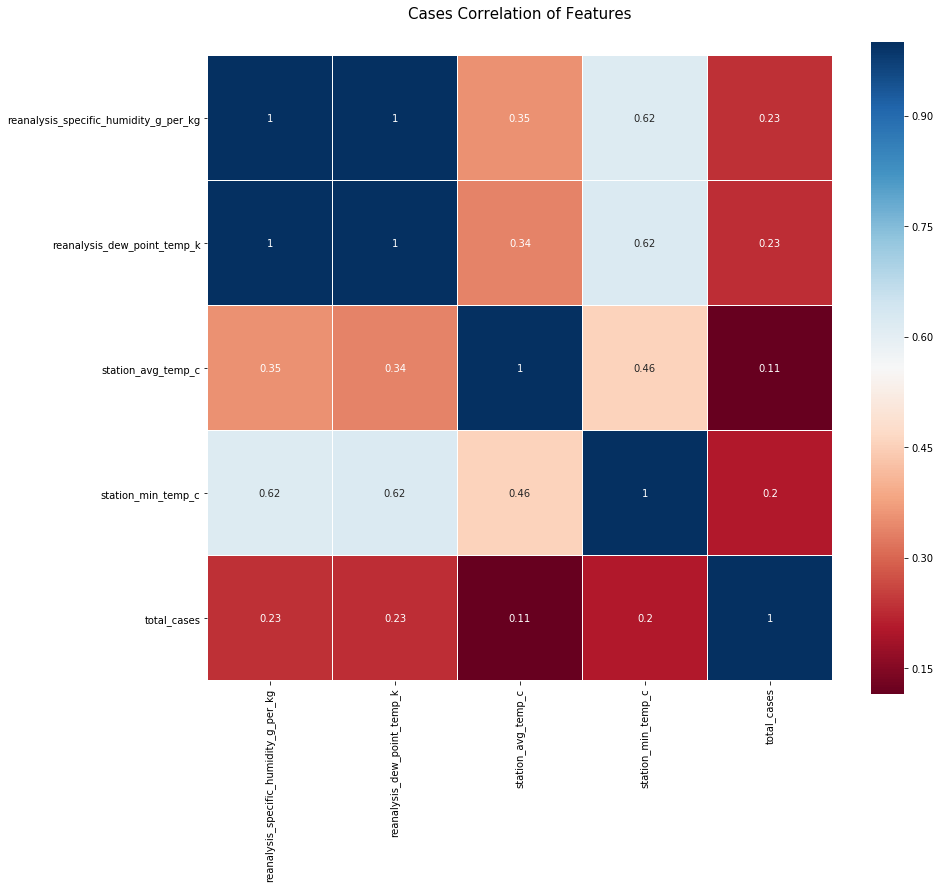

In [132]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Cases Correlation of Features', y=1.05, size=15)
sns.heatmap(iq_train_features.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [87]:
# Some useful parameters which will come in handy later on
ntrain = sj_train_features.shape[0]
ntest = sj_test_features.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [133]:
# Some useful parameters which will come in handy later on
ntrain = iq_train_features.shape[0]
ntest = iq_test_features.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [134]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [135]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 5
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 5
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# LinearRegression parameters 
lr_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
    }

In [136]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
lr = SklearnHelper(clf=LinearRegression, seed=SEED, params=lr_params)

NameError: name 'LinearRegression' is not defined

In [101]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
sj_train_y = sj_train_labels['total_cases'].ravel()
sj_train_features = sj_train_features.drop(['total_cases'], axis=1)
sj_train_X = sj_train_features.values # Creates an array of the train data
sj_test = sj_test_features.values # Creats an array of the test data
print('labels  : ', sj_train_features.shape)
print('labels  : ', sj_test_features.shape)
print(sj_train_features)

KeyError: "['total_cases'] not found in axis"

In [155]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
iq_train_y = iq_train_labels['total_cases'].ravel()
iq_train_features = iq_train_features.drop(['total_cases'], axis=1)
iq_train_X = iq_train_features.values # Creates an array of the train data
iq_test = iq_test_features.values # Creats an array of the test data
print('labels  : ', iq_train_features.shape)
print('labels  : ', iq_test_features.shape)
print(iq_train_features)

KeyError: "['total_cases'] not found in axis"

In [102]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, sj_train_X, sj_train_y, sj_test) # Extra Trees
# rf_oof_train, rf_oof_test = get_oof(rf,sj_train_X, sj_train_y, sj_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, sj_train_X, sj_train_y, sj_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,sj_train_X, sj_train_y, sj_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,sj_train_X, sj_train_y, sj_test) # Support Vector Classifier
lr_oof_train, lr_oof_test = get_oof(lr,sj_train_X, sj_train_y, sj_test) # Inear Regression

print("Training is complete")

      Iter       Train Loss   Remaining Time 
         1   201202156.7822            2.56m
         2 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.62m
         3 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.59m
         4 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.60m
         5 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.59m
         6 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.62m
         7 1770735171885454474665478539477144063081936805032875084822474448295090527365232318720306382366902283915793786145341440.0000            2.5

        51 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            2.18m
        52 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            2.17m
        53 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            2.16m
        54 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            2.15m
        55 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            2.14m
        56 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861

        99 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.87m
       100 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.86m
       101 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.86m
       102 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.85m
       103 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.84m
       104 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861

       147 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.56m
       148 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.55m
       149 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.55m
       150 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.54m
       151 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.54m
       152 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861

       195 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.36m
       196 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.35m
       197 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.35m
       198 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.34m
       199 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861838970880.0000            1.34m
       200 108997411466716011624521651047283210056205809749805824539590487542337466537723519424167873868729828388144832926366492572966559861

       242 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            1.16m
       243 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            1.15m
       244 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            1.15m
       245 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            1.14m
       246 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            1.14m
       247 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

       289 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           57.09s
       290 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           56.83s
       291 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           56.52s
       292 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           56.23s
       293 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           55.97s
       294 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

       336 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           43.95s
       337 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           43.66s
       338 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           43.39s
       339 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           43.12s
       340 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           42.83s
       341 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

       383 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           31.27s
       384 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           31.00s
       385 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           30.72s
       386 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           30.44s
       387 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           30.16s
       388 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

       430 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           18.78s
       431 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           18.50s
       432 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           18.23s
       433 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           17.95s
       434 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000           17.67s
       435 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

       477 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            6.05s
       478 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            5.78s
       479 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            5.52s
       480 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            5.26s
       481 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559045766022439017699948323073553312473967230976.0000            4.99s
       482 613279165652790877242493967543506805149834566823809175424097345545616276796914423884301633686259559

        28 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.51m
        29 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.57m
        30 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.55m
        31 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.52m
        32 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.50m
        33 130664790729566816962884980497395179599807634952110699110920564534729575937227703433654472573740451058539435223087579136.0000            2.48m
        34 13066479073022517649137969297826327641352704573699888807495970635

        78 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            2.19m
        79 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            2.20m
        80 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            2.20m
        81 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            2.19m
        82 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            2.20m
        83 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       126 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.80m
       127 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.80m
       128 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.79m
       129 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.78m
       130 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.78m
       131 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       174 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.50m
       175 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.49m
       176 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.49m
       177 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.48m
       178 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.48m
       179 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       222 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.24m
       223 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.24m
       224 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.23m
       225 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.23m
       226 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000            1.22m
       227 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       270 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           59.71s
       271 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           59.46s
       272 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           59.17s
       273 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           58.90s
       274 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           58.66s
       275 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       318 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           46.93s
       319 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           46.67s
       320 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           46.45s
       321 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           46.16s
       322 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034128914073817570082816.0000           45.91s
       323 21914631546802039608149263070393214158941569509825565244513591487322064759407822802603668803934252760555463381889074034

       365 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           34.54s
       366 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           34.28s
       367 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           34.01s
       368 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           33.76s
       369 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           33.49s
       370 439282819795109252343577169799237846777805973800987451555431563199116

       410 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           22.77s
       411 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           22.52s
       412 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           22.25s
       413 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           21.99s
       414 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           21.73s
       415 439282819795109252343577169799237846777805973800987451555431563199116

       455 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           11.29s
       456 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           11.03s
       457 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           10.78s
       458 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           10.53s
       459 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000           10.28s
       460 439282819795109252343577169799237846777805973800987451555431563199116

       500 439282819795109252343577169799237846777805973800987451555431563199116860747919650240233535664567492818494015720438424406349364792032770314580642496512.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1 235585502821234003018041925065244672.0000            2.88m
         2 173225744263620934101074901373744208339604715256137795190870820495016907851562046956735089403612580088420430249984.0000            2.77m
         3 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.71m
         4 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.64m
         5 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            3.02m
      

        46 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.15m
        47 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.14m
        48 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.13m
        49 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.12m
        50 3407399955374391414872477086702420932295596437678909318782034911876232136697265736938289465658263388181949064410448238073297299304081221580056690688.0000            2.10m
        51 3407399955374391414872477086702420932295596437678909318782034911876232136697265

        91 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.77m
        92 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.77m
        93 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.76m
        94 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.75m
        95 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.75m
        96 1364355300343839663203299679604518637406769822437488483603825329

       136 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.53m
       137 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.53m
       138 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.53m
       139 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.52m
       140 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.52m
       141 1364355300343839663203299679604518637406769822437488483603825329

       181 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.52m
       182 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.51m
       183 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.50m
       184 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.50m
       185 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.50m
       186 1364355300343839663203299679604518637406769822437488483603825329

       226 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.31m
       227 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.31m
       228 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.30m
       229 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.30m
       230 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.30m
       231 1364355300343839663203299679604518637406769822437488483603825329

       271 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.13m
       272 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.13m
       273 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.12m
       274 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.12m
       275 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.12m
       276 1364355300343839663203299679604518637406769822437488483603825329

       316 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           57.50s
       317 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           57.21s
       318 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           56.91s
       319 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           56.64s
       320 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           56.37s
       321 1364355300343839663203299679604518637406769822437488483603825329

       361 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           43.96s
       362 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           43.61s
       363 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           43.26s
       364 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           42.90s
       365 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           42.55s
       366 1364355300343839663203299679604518637406769822437488483603825329

       406 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           29.07s
       407 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           28.74s
       408 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           28.41s
       409 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           28.08s
       410 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           27.75s
       411 1364355300343839663203299679604518637406769822437488483603825329

       451 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           14.71s
       452 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           14.40s
       453 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           14.09s
       454 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           13.78s
       455 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000           13.48s
       456 1364355300343839663203299679604518637406769822437488483603825329

       496 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            1.19s
       497 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            0.89s
       498 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            0.59s
       499 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            0.30s
       500 1364355300343839663203299679604518637406769822437488483603825329740904279443616702565654198957298231941849125411625499588595197991256075935411320389632.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1   624460364.5010  

        47 14941727027082651462885803783147427275748920671898640242596482572121490039089812240192106330459851508761500199102147984304016164762257675272585216.0000            3.47m
        48 14941727027082651462885803783147427275748920671898640242596482572121490039089812240192106330459851508761500199102147984304016164762257675272585216.0000            3.46m
        49 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            3.44m
        50 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            3.42m
        51 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            3.40m
        52 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

        93 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.87m
        94 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.86m
        95 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.85m
        96 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.84m
        97 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.83m
        98 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       139 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.46m
       140 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.46m
       141 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.45m
       142 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.44m
       143 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.43m
       144 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       185 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.12m
       186 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.11m
       187 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.11m
       188 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.10m
       189 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            2.09m
       190 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       231 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.79m
       232 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.78m
       233 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.78m
       234 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.77m
       235 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.77m
       236 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       277 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.48m
       278 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.47m
       279 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.46m
       280 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.46m
       281 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.45m
       282 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       323 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.16m
       324 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.16m
       325 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.15m
       326 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.14m
       327 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000            1.13m
       328 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       369 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           50.14s
       370 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           49.73s
       371 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           49.31s
       372 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           48.90s
       373 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           48.49s
       374 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       415 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           31.77s
       416 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           31.37s
       417 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           30.98s
       418 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           30.59s
       419 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           30.20s
       420 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

       461 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           14.29s
       462 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           13.92s
       463 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           13.55s
       464 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           13.17s
       465 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704353440138014058784236261102923450179287700176321900445696.0000           12.80s
       466 14941727028631242940446161298519163165876515781941959077935383645685706294454690533027704

         9 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873990803456.0000            2.83m
        10 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873990803456.0000            2.81m
        11 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873990803456.0000            2.79m
        12 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873990803456.0000            2.78m
        13 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873990803456.0000            2.77m
        14 236800841093187098629281856321431174830410731387581206224554994580657235955011704592714633041602416643972021808278067644663035873

        55 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            2.35m
        56 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            2.34m
        57 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            2.32m
        58 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            2.31m
        59 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            2.30m
        60 16896667098941546691030252408875697821112187180512556125639355033408997395

       100 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.97m
       101 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.97m
       102 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.96m
       103 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.95m
       104 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.94m
       105 16896667098941546691030252408875697821112187180512556125639355033408997395

       145 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.73m
       146 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.72m
       147 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.71m
       148 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.71m
       149 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.70m
       150 16896667098941546691030252408875697821112187180512556125639355033408997395

       190 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.46m
       191 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.46m
       192 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.45m
       193 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.45m
       194 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.44m
       195 16896667098941546691030252408875697821112187180512556125639355033408997395

       235 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.27m
       236 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.27m
       237 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.26m
       238 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.26m
       239 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.25m
       240 16896667098941546691030252408875697821112187180512556125639355033408997395

       280 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.06m
       281 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.05m
       282 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.05m
       283 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.04m
       284 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000            1.04m
       285 16896667098941546691030252408875697821112187180512556125639355033408997395

       325 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           50.34s
       326 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           50.04s
       327 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           49.74s
       328 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           49.44s
       329 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           49.14s
       330 16896667098941546691030252408875697821112187180512556125639355033408997395

       370 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           38.68s
       371 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           38.40s
       372 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           38.12s
       373 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           37.83s
       374 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           37.55s
       375 16896667098941546691030252408875697821112187180512556125639355033408997395

       415 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           25.70s
       416 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           25.40s
       417 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           25.10s
       418 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           24.81s
       419 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           24.52s
       420 16896667098941546691030252408875697821112187180512556125639355033408997395

       460 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           12.24s
       461 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           11.94s
       462 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           11.63s
       463 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           11.33s
       464 16896667098941546691030252408875697821112187180512556125639355033408997395340492246903194402572812069848150482954594930271052946419030312666116653056.0000           11.03s
       465 16896667098941546691030252408875697821112187180512556125639355033408997395

In [140]:
# Create our OOF train and test predictions. These base results will be used as new features IQ
et_oof_train, et_oof_test = get_oof(et, iq_train_X, iq_train_y, iq_test) # Extra Trees
# rf_oof_train, rf_oof_test = get_oof(rf,sj_train_X, sj_train_y, sj_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, iq_train_X, iq_train_y, iq_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,iq_train_X, iq_train_y, iq_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,iq_train_X, iq_train_y, iq_test) # Support Vector Classifier
# lr_oof_train, lr_oof_test = get_oof(lr,iq_train_X, iq_train_y, iq_test) # Inear Regression

print("Training is complete")

building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500

building tree 9 of 500building tree 10 of 500

building tree 11 of 500
building tree 12 of 500building tree 13 of 500

building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500building tree 21 of 500

building tree 22 of 500building tree 23 of 500

building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500
building tree 30 of 500
building tree 31 of 500

building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s


building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500building tree 368 of 500

building tree 369 of 500building tree 370 of 500building tree 371 of 500


building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500building tree 378 of 500
building tree 379 of 500

building tree 380 of 500
building tree 381 of 500
building tree 382 of 500building tree 383 of 500

building tree 384 of 500building tree 385 of 500

building tree 386 of 500building tree 387 of 500

building tree 388 of 500
building tree 389 of 500
building tree 390 of 500building tree 391 of 500building tree 392 of 500


building tree 393 of 500
building tree 394 of 500
building tree 395 of 500building tree 396 of 500

building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500building tree 402 of 500

building tree 403 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500building tree 11 of 500

building tree 12 of 500
building tree 13 of 500building tree 14 of 500building tree 15 of 500

building tree 16 of 500

building tree 17 of 500
building tree 18 of 500building tree 19 of 500
building tree 20 of 500

building tree 21 of 500
building tree 22 of 500
building tree 23 of 500building tree 24 of 500

building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500building tree 31 of 500

building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500building tree 40 of 500building tree 41 of 500

building tree 42 of 500
bu

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s


building tree 358 of 500building tree 359 of 500

building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500building tree 365 of 500

building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500building tree 370 of 500

building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500building tree 376 of 500

building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500building tree 384 of 500building tree 385 of 500


building tree 386 of 500
building tree 387 of 500
building tree 388 of 500building tree 389 of 500

building tree 390 of 500
building tree 391 of 500building tree 392 of 500building tree 393 of 500


building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500

building tree 7 of 500
building tree 8 of 500
building tree 9 of 500building tree 10 of 500
building tree 11 of 500

building tree 12 of 500
building tree 13 of 500
building tree 14 of 500building tree 15 of 500

building tree 16 of 500
building tree 17 of 500
building tree 18 of 500building tree 19 of 500

building tree 20 of 500
building tree 21 of 500
building tree 22 of 500building tree 23 of 500

building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500building tree 28 of 500

building tree 29 of 500
building tree 30 of 500
building tree 31 of 500building tree 32 of 500building tree 33 of 500


building tree 34 of 500building tree 35 of 500

building tree 36 of 500
building tree 37 of 500building tree 38 of 500
building tree 39 of 500

building tree 40 of 500
building tree 41 of 500building tree 42 of 500

b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s


building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500building tree 282 of 500

building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500building tree 288 of 500building tree 289 of 500


building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500building tree 294 of 500
building tree 295 of 500
building tree 296 of 500building tree 297 of 500


building tree 298 of 500building tree 299 of 500

building tree 300 of 500
building tree 301 of 500building tree 302 of 500

building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


building tree 493 of 500building tree 494 of 500
building tree 495 of 500

building tree 496 of 500
building tree 497 of 500building tree 498 of 500

building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500

building tree 7 of 500
building tree 8 of 500
building tree 9 of 500building tree 10 of 500

building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500building tree 15 of 500

building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500building tree 22 of 500

building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500

building tree 30 of 500building tree 31 of 500

building tree 32 of 500
building tree 33 of 500building tree 34 of 500
building tree 35 of 500

building tree 36 of 500
building tree 37 of 500building tree 38 of 500

building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500bu

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s



building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500building tree 373 of 500
building tree 374 of 500
building tree 375 of 500

building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500building tree 385 of 500

building tree 386 of 500
building tree 387 of 500building tree 388 of 500

building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500building tree 395 of 500
building tree 396 of 500
building tree 397 of 500

building tree 398 of 500
building tree 399 of 500
building tree 400 of 500building tree 401 of 500
building tree 402 of 500

building tree 403 of 500
building tree 404 of 500
building tree 405 of 500building tree 406 of 500

building tree 407 of 500

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500building tree 7 of 500
building tree 8 of 500

building tree 9 of 500building tree 10 of 500
building tree 11 of 500building tree 12 of 500

building tree 13 of 500

building tree 14 of 500building tree 15 of 500building tree 16 of 500


building tree 17 of 500
building tree 18 of 500building tree 19 of 500

building tree 20 of 500building tree 21 of 500
building tree 22 of 500

building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500

building tree 30 of 500building tree 31 of 500building tree 32 of 500

building tree 33 of 500

building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500building tree 39 of 500
building tree 40 of 500

building tree 41 of 500
building tree 42 of 500bu

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s


building tree 352 of 500

building tree 353 of 500
building tree 354 of 500
building tree 355 of 500building tree 356 of 500

building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500building tree 362 of 500

building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500building tree 368 of 500

building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500building tree 378 of 500building tree 379 of 500


building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500building tree 384 of 500

building tree 385 of 500
building tree 386 of 500building tree 387 of 500building tree 388 of 500


building tree 389 of 500
building tree 390 of 500
building tree 391 of 500

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished


      Iter       Train Loss   Remaining Time 
         1         948.5993           29.63s
         2         752.4924           27.82s
         3         644.1811           27.09s
         4         562.0018           27.07s
         5         505.1772           27.87s
         6         451.0132           27.51s
         7         402.4253           27.23s
         8         362.0173           27.45s
         9         329.8280           27.47s
        10         303.1577           27.23s
        11         280.7449           26.98s
        12         257.4865           26.82s
        13         236.7568           27.05s
        14         218.4185           26.84s
        15         201.9613           26.64s
        16         187.8067           26.56s
        17         173.2581           26.74s
        18         161.9474           26.55s
        19         151.5320           26.37s
        20         141.9740           26.28s
        21         132.5862           26.42s
        2

       183           4.5067           12.11s
       184           4.5052           12.07s
       185           4.5018           12.02s
       186           4.4994           11.97s
       187           4.4973           11.91s
       188           4.4948           11.85s
       189           4.4924           11.79s
       190           4.4898           11.74s
       191           4.4880           11.70s
       192           4.4867           11.65s
       193           4.4849           11.60s
       194           4.4837           11.54s
       195           4.4819           11.49s
       196           4.4796           11.43s
       197           4.4781           11.38s
       198           4.4768           11.34s
       199           4.4760           11.29s
       200           4.4748           11.24s
       201           4.4744           11.19s
       202           4.4736           11.13s
       203           4.4720           11.08s
       204           4.4714           11.03s
       205

       371           4.4262            4.31s
       372           4.4259            4.27s
       373           4.4257            4.24s
       374           4.4257            4.20s
       375           4.4257            4.16s
       376           4.4255            4.13s
       377           4.4255            4.09s
       378           4.4255            4.06s
       379           4.4252            4.02s
       380           4.4248            3.99s
       381           4.4245            3.96s
       382           4.4243            3.92s
       383           4.4240            3.89s
       384           4.4239            3.85s
       385           4.4238            3.81s
       386           4.4237            3.78s
       387           4.4237            3.75s
       388           4.4236            3.71s
       389           4.4236            3.68s
       390           4.4233            3.64s
       391           4.4233            3.61s
       392           4.4233            3.57s
       393

        53          24.2215           22.04s
        54          23.3251           21.98s
        55          22.1893           21.83s
        56          21.2188           21.67s
        57          20.3313           21.50s
        58          19.5301           21.34s
        59          18.8003           21.21s
        60          18.1440           21.16s
        61          17.4745           21.04s
        62          16.8460           20.90s
        63          16.0541           20.75s
        64          15.4315           20.60s
        65          14.9442           20.51s
        66          14.4190           20.45s
        67          13.9239           20.33s
        68          13.4843           20.19s
        69          13.0467           20.05s
        70          12.5929           19.91s
        71          12.1205           19.79s
        72          11.6948           19.75s
        73          11.4181           19.65s
        74          10.9848           19.52s
        75

       243           3.0863            8.95s
       244           3.0858            8.92s
       245           3.0851            8.88s
       246           3.0846            8.84s
       247           3.0843            8.79s
       248           3.0837            8.75s
       249           3.0834            8.70s
       250           3.0825            8.66s
       251           3.0819            8.62s
       252           3.0815            8.59s
       253           3.0809            8.55s
       254           3.0804            8.50s
       255           3.0802            8.46s
       256           3.0798            8.41s
       257           3.0794            8.37s
       258           3.0792            8.32s
       259           3.0790            8.28s
       260           3.0785            8.25s
       261           3.0781            8.21s
       262           3.0777            8.17s
       263           3.0769            8.13s
       264           3.0768            8.08s
       265

       426           3.0647            2.32s
       427           3.0646            2.29s
       428           3.0646            2.26s
       429           3.0643            2.23s
       430           3.0643            2.20s
       431           3.0642            2.16s
       432           3.0642            2.13s
       433           3.0642            2.10s
       434           3.0642            2.07s
       435           3.0641            2.04s
       436           3.0641            2.01s
       437           3.0641            1.97s
       438           3.0641            1.94s
       439           3.0641            1.91s
       440           3.0641            1.88s
       441           3.0640            1.84s
       442           3.0640            1.81s
       443           3.0640            1.78s
       444           3.0640            1.75s
       445           3.0640            1.72s
       446           3.0640            1.69s
       447           3.0639            1.65s
       448

       110           5.4431           16.18s
       111           5.3444           16.13s
       112           5.2625           16.05s
       113           5.1578           15.96s
       114           5.0874           15.87s
       115           5.0215           15.78s
       116           4.9614           15.68s
       117           4.8653           15.59s
       118           4.7897           15.53s
       119           4.7291           15.46s
       120           4.6662           15.37s
       121           4.6035           15.29s
       122           4.5397           15.20s
       123           4.4958           15.11s
       124           4.4423           15.03s
       125           4.3938           14.95s
       126           4.3387           14.89s
       127           4.2739           14.82s
       128           4.2215           14.74s
       129           4.1812           14.65s
       130           4.1361           14.57s
       131           4.1028           14.49s
       132

       297           3.0374            6.30s
       298           3.0374            6.26s
       299           3.0374            6.23s
       300           3.0373            6.19s
       301           3.0373            6.16s
       302           3.0372            6.12s
       303           3.0371            6.08s
       304           3.0370            6.05s
       305           3.0370            6.01s
       306           3.0369            5.97s
       307           3.0369            5.94s
       308           3.0369            5.91s
       309           3.0368            5.87s
       310           3.0368            5.83s
       311           3.0367            5.80s
       312           3.0366            5.76s
       313           3.0366            5.72s
       314           3.0365            5.69s
       315           3.0364            5.65s
       316           3.0364            5.63s
       317           3.0363            5.60s
       318           3.0363            5.59s
       319

       487           3.0123            0.36s
       488           3.0122            0.34s
       489           3.0121            0.31s
       490           3.0121            0.28s
       491           3.0120            0.25s
       492           3.0120            0.22s
       493           3.0119            0.20s
       494           3.0117            0.17s
       495           3.0117            0.14s
       496           3.0117            0.11s
       497           3.0116            0.08s
       498           3.0116            0.06s
       499           3.0116            0.03s
       500           3.0116            0.00s
      Iter       Train Loss   Remaining Time 
         1         924.6246           28.36s
         2         749.7810           30.72s
         3         633.2547           29.24s
         4         557.4457           28.14s
         5         489.0008           28.07s
         6         428.9808           28.62s
         7         385.9110           28.13s
         

       169           4.5566           12.59s
       170           4.5525           12.54s
       171           4.5486           12.49s
       172           4.5425           12.43s
       173           4.5374           12.37s
       174           4.5322           12.31s
       175           4.5292           12.25s
       176           4.5266           12.19s
       177           4.5225           12.15s
       178           4.5180           12.10s
       179           4.5152           12.05s
       180           4.5116           11.99s
       181           4.5086           11.93s
       182           4.5056           11.87s
       183           4.5040           11.82s
       184           4.5015           11.76s
       185           4.5001           11.71s
       186           4.4963           11.67s
       187           4.4941           11.62s
       188           4.4914           11.56s
       189           4.4887           11.51s
       190           4.4868           11.45s
       191

       352           4.4062            4.87s
       353           4.4059            4.84s
       354           4.4057            4.81s
       355           4.4047            4.77s
       356           4.4043            4.74s
       357           4.4038            4.70s
       358           4.4035            4.66s
       359           4.4032            4.63s
       360           4.4031            4.60s
       361           4.4030            4.56s
       362           4.4030            4.53s
       363           4.4030            4.49s
       364           4.4030            4.46s
       365           4.4029            4.42s
       366           4.4026            4.39s
       367           4.4025            4.35s
       368           4.4025            4.32s
       369           4.4024            4.28s
       370           4.4024            4.25s
       371           4.4024            4.22s
       372           4.4014            4.18s
       373           4.4011            4.15s
       374

        36          78.8542           21.65s
        37          75.5481           21.64s
        38          72.1885           21.52s
        39          68.8747           21.35s
        40          64.7964           21.18s
        41          61.5732           21.01s
        42          58.5692           20.98s
        43          55.8207           20.88s
        44          53.2627           20.73s
        45          50.6824           20.57s
        46          48.6277           20.41s
        47          46.3456           20.24s
        48          44.0005           20.09s
        49          41.6590           20.06s
        50          39.6759           19.94s
        51          37.8609           19.78s
        52          35.8296           19.63s
        53          34.5942           19.47s
        54          33.3035           19.32s
        55          32.0081           19.28s
        56          30.6376           19.18s
        57          29.3029           19.04s
        58

       225           3.0665            8.41s
       226           3.0651            8.39s
       227           3.0642            8.35s
       228           3.0619            8.31s
       229           3.0614            8.27s
       230           3.0607            8.23s
       231           3.0597            8.18s
       232           3.0578            8.14s
       233           3.0572            8.10s
       234           3.0561            8.06s
       235           3.0549            8.03s
       236           3.0544            7.99s
       237           3.0538            7.96s
       238           3.0534            7.91s
       239           3.0524            7.87s
       240           3.0519            7.83s
       241           3.0507            7.79s
       242           3.0498            7.75s
       243           3.0494            7.71s
       244           3.0488            7.68s
       245           3.0471            7.65s
       246           3.0465            7.61s
       247

       408           3.0300            2.48s
       409           3.0300            2.45s
       410           3.0300            2.42s
       411           3.0300            2.40s
       412           3.0299            2.37s
       413           3.0299            2.34s
       414           3.0298            2.31s
       415           3.0298            2.28s
       416           3.0298            2.26s
       417           3.0298            2.23s
       418           3.0298            2.20s
       419           3.0298            2.17s
       420           3.0297            2.15s
       421           3.0297            2.12s
       422           3.0297            2.09s
       423           3.0297            2.06s
       424           3.0297            2.03s
       425           3.0296            2.01s
       426           3.0296            1.98s
       427           3.0296            1.95s
       428           3.0295            1.92s
       429           3.0295            1.90s
       430

In [137]:
# Create our OOF train and test predictions. These base results will be used as new features IQ
et_oof_train, et_oof_test = get_oof(et, iq_train_X, iq_train_y, iq_test) # Extra Trees
# rf_oof_train, rf_oof_test = get_oof(rf,sj_train_X, sj_train_y, sj_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, iq_train_X, iq_train_y, iq_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,iq_train_X, iq_train_y, iq_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,iq_train_X, iq_train_y, iq_test) # Support Vector Classifier
# lr_oof_train, lr_oof_test = get_oof(lr,iq_train_X, iq_train_y, iq_test) # Inear Regression

print("Training is complete")

NameError: name 'iq_train_X' is not defined

In [103]:
# rf_feature = rf.feature_importances(sj_train_X,sj_train_y)
et_feature = et.feature_importances(sj_train_X, sj_train_y)
ada_feature = ada.feature_importances(sj_train_X, sj_train_y)
gb_feature = gb.feature_importances(sj_train_X,sj_train_y)


[0.25264209 0.25464901 0.26401845 0.22669044]
[0.28  0.314 0.372 0.034]
      Iter       Train Loss   Remaining Time 
         1 2927397625251469.0000            3.71m
         2 4686398518589773269533486373372629718587539504465828344920101609034605590023201334522694678414884864.0000            3.64m
         3 2789824315157598088816456408724415644553867277015284420238577134309484837546544537184146433567535254208512.0000            3.63m
         4 4860213194577851693300106026304009936585210856187935780575466879023646844489016605975548403399112900634442086341488662282240.0000            3.56m
         5 4860213194577851693300106026304009936585210856187935780575466879023646844489016605975548403399112900634442086341488662282240.0000            3.53m
         6 4860213194577851693300106026304009936585210856187935780575466879023646844489016605975548403399112900634442086341488662282240.0000            3.50m
         7 4860213194577851693300106026304009936585210856187935780575466879023646844

        50 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            3.04m
        51 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            3.04m
        52 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            3.02m
        53 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            3.01m
        54 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            3.00m
        55 19839545360341800968733859752781925886956879656921042704559634025572354212

        95 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.69m
        96 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.69m
        97 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.69m
        98 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.70m
        99 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.70m
       100 19839545360341800968733859752781925886956879656921042704559634025572354212

       140 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.55m
       141 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.54m
       142 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.54m
       143 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.53m
       144 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.53m
       145 19839545360341800968733859752781925886956879656921042704559634025572354212

       185 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.27m
       186 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.27m
       187 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.26m
       188 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.25m
       189 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            2.25m
       190 19839545360341800968733859752781925886956879656921042704559634025572354212

       230 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.97m
       231 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.96m
       232 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.96m
       233 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.95m
       234 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.94m
       235 19839545360341800968733859752781925886956879656921042704559634025572354212

       275 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.65m
       276 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.65m
       277 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.64m
       278 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.63m
       279 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.63m
       280 19839545360341800968733859752781925886956879656921042704559634025572354212

       320 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.32m
       321 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.32m
       322 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.31m
       323 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.30m
       324 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            1.29m
       325 19839545360341800968733859752781925886956879656921042704559634025572354212

       365 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           57.94s
       366 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           57.47s
       367 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           57.02s
       368 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           56.55s
       369 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           56.09s
       370 19839545360341800968733859752781925886956879656921042704559634025572354212

       410 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           37.72s
       411 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           37.29s
       412 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           36.85s
       413 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           36.41s
       414 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           35.97s
       415 19839545360341800968733859752781925886956879656921042704559634025572354212

       455 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           18.62s
       456 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           18.21s
       457 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           17.82s
       458 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           17.40s
       459 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000           17.00s
       460 19839545360341800968733859752781925886956879656921042704559634025572354212

       500 19839545360341800968733859752781925886956879656921042704559634025572354212284431186464284078170891012966717863065267746971807123574601479476758970368.0000            0.00s
[0.31841945 0.29679587 0.3271948  0.04593316]


In [141]:
# rf_feature = rf.feature_importances(sj_train_X,sj_train_y) iq
et_feature = et.feature_importances(iq_train_X, iq_train_y)
ada_feature = ada.feature_importances(iq_train_X, iq_train_y)
gb_feature = gb.feature_importances(iq_train_X,iq_train_y)

building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500building tree 5 of 500
building tree 6 of 500
building tree 7 of 500


building tree 8 of 500
building tree 9 of 500building tree 10 of 500building tree 11 of 500


building tree 12 of 500building tree 13 of 500

building tree 14 of 500building tree 15 of 500building tree 16 of 500


building tree 17 of 500
building tree 18 of 500building tree 19 of 500

building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500building tree 30 of 500


building tree 31 of 500
building tree 32 of 500building tree 33 of 500

building tree 34 of 500
building tree 35 of 500building tree 36 of 500
building tree 37 of 500
building tree 38 of 500

building tree 39 of 500building tree 40 of 500
building tree 41 of 500

building tree 42 of 500
b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.2s


building tree 344 of 500
building tree 345 of 500
building tree 346 of 500building tree 347 of 500

building tree 348 of 500
building tree 349 of 500building tree 350 of 500

building tree 351 of 500building tree 352 of 500

building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500building tree 357 of 500
building tree 358 of 500

building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500building tree 372 of 500

building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


[0.26554984 0.25974254 0.19032993 0.24237769]
[0.122 0.158 0.39  0.33 ]
      Iter       Train Loss   Remaining Time 
         1        1240.3615           33.37s
         2         993.6294           48.52s
         3         857.9098           53.23s
         4         756.0497           47.98s
         5         676.2958           44.16s
         6         602.5721           41.88s
         7         546.8107           41.28s
         8         494.8530           40.27s
         9         456.4138           39.29s
        10         422.4965           38.66s
        11         391.1675           39.08s
        12         365.1332           38.29s
        13         338.6257           37.60s
        14         314.9310           37.50s
        15         293.3641           37.02s
        16         274.6106           36.54s
        17         255.3220           36.51s
        18         238.6235           36.04s
        19         223.7660           36.09s
        20         209.7475

       182           4.8678           16.38s
       183           4.8567           16.31s
       184           4.8445           16.24s
       185           4.8344           16.15s
       186           4.8208           16.07s
       187           4.8105           15.99s
       188           4.8002           15.91s
       189           4.7892           15.84s
       190           4.7777           15.77s
       191           4.7701           15.68s
       192           4.7578           15.60s
       193           4.7483           15.53s
       194           4.7368           15.46s
       195           4.7279           15.40s
       196           4.7204           15.33s
       197           4.7117           15.25s
       198           4.7013           15.17s
       199           4.6930           15.09s
       200           4.6862           15.02s
       201           4.6769           14.96s
       202           4.6702           14.89s
       203           4.6642           14.81s
       204

       371           4.4943            5.43s
       372           4.4942            5.39s
       373           4.4942            5.35s
       374           4.4942            5.30s
       375           4.4942            5.26s
       376           4.4938            5.21s
       377           4.4938            5.16s
       378           4.4933            5.12s
       379           4.4920            5.08s
       380           4.4916            5.03s
       381           4.4916            4.99s
       382           4.4916            4.94s
       383           4.4911            4.90s
       384           4.4911            4.85s
       385           4.4911            4.81s
       386           4.4908            4.76s
       387           4.4903            4.72s
       388           4.4893            4.68s
       389           4.4892            4.65s
       390           4.4891            4.61s
       391           4.4891            4.57s
       392           4.4891            4.52s
       393

In [142]:
# rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
#   ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [0.25264209, 0.25464901, 0.26401845, 0.22669044]
ada_features = [0.28,  0.314, 0.372, 0.034]
gb_features = [0.31841945, 0.29679587, 0.3271948, 0.04593316]

In [109]:
cols = sj_train_features.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
#      'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [143]:
cols = iq_train_features.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
#      'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [144]:
# # Scatter plot 
# trace = go.Scatter(
#     y = feature_dataframe['Random Forest feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Random Forest feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Random Forest Feature Importance',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
   showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
            ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [145]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,reanalysis_specific_humidity_g_per_kg,0.252642,0.280,0.318419,0.283687
1,reanalysis_dew_point_temp_k,0.254649,0.314,0.296796,0.288482
2,station_avg_temp_c,0.264018,0.372,0.327195,0.321071


In [146]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [147]:
base_predictions_train = pd.DataFrame( {
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,ExtraTrees,AdaBoost,GradientBoost
0,1.0,13.0,2.0
1,1.0,25.0,1.0
2,2.0,25.0,2.0
3,3.0,37.0,3.0
4,0.0,37.0,4.0


In [148]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [150]:
x_train_iq = np.concatenate(( et_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test_iq = np.concatenate(( et_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [151]:
x_train_sj = np.concatenate(( et_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test_sj = np.concatenate(( et_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [160]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 verbose = 5,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, sj_train_y)
predictions_sj = gbm.predict(sj_test)

In [161]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 verbose = 5,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_iq, iq_train_y)
predictions_iq = gbm.predict(iq_test)

In [164]:
# Generate Submission File 
total_preds = list(predictions_sj) + list(predictions_iq)
print(total_preds)

# StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
#                             'Survived': predictions })
# StackingSubmission.to_csv("StackingSubmission.csv", index=False)
submission_format = pd.read_csv('./dataset/submission_format.csv')

submission_format['total_cases'] = total_preds
# submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

# Save to CSV, use current date
submission_format.to_csv('submissions/StackingSubmission.csv', index=False)

[3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 3, 6, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 6, 6, 6, 3, 6, 3, 3, 3, 3, 6, 3, 3, 6, 6, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 